In [ ]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.files import InterProScanFile
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import glob
from src import get_genome_id
import os
from scipy.stats import pearsonr
from src.tools import MMSeqs
import dataframe_image as dfi
import warnings
import re
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}


# TODO: How does the model behave on short sequences versus long sequences? Is it picking up the spurious short ORFs?
# TODO: Find the pairwise distances between AntiFam sequences and model-predicted spurious sequences. 
# TODO: What fraction of each category are predicted spurious?
# TODO: I wonder if I could re-try fine-tuning by selecting sequences which are real and spurious with high probability (maybe 0.95 cutoff).
# TODO: Find a way to see if the model is robust to truncation and/or extension. 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# for path in glob.glob('../data/ref/*_ref.csv'):
#     genome_id = get_genome_id(path)
#     prodigal_df = FASTAFile(f'../data/prodigal/{genome_id}_protein.faa').to_df(prodigal_output=True)
#     ref_df = pd.read_csv(path, index_col=0).loc[prodigal_df.index]
#     assert np.all(prodigal_df.index == ref_df.index), 'The indices in the FASTA file do not match the reference output.'
#     print((ref_df.query_seq == 'none').sum(), f'missing sequences in {path}')
#     ref_df['query_seq'] = prodigal_df['seq']
#     ref_df.to_csv(path)

In [106]:
def apply_threshold(results_df:pd.DataFrame, threshold:float=0.5, class_:int=0):
    results_df['model_label'] = np.where(results_df[f'model_output_{class_}'] >= threshold, class_, int(not class_))
    return results_df

def load_interpro(genome_ids, dir_:str='../data/interpro/'):
    df = [InterProScanFile(os.path.join(dir_, f'{genome_id}_annotation.tsv')).to_df() for genome_id in tqdm(genome_ids, desc='load_interpro')]
    return pd.concat(df) 

def has_interpro_hit(df:pd.DataFrame, max_e_value:float=2000, include_mdb:bool=True):
    has_hit = ~df.interpro_analysis.isin(['AntiFam', 'none']) # Don't include the AntiFam hits as "hits."
    e_values = df.interpro_e_value
    if include_mdb: # Because the MobiDBLite hits don't have an associated E-value.
        e_values = e_values.fillna(max_e_value) 
    return has_hit & (e_values <= max_e_value)

has_antifam_hit = lambda df : df.interpro_analysis == 'AntiFam'

is_suspect = lambda df : (df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction')
is_suspect_match = lambda df : is_suspect(df) & (df.category == 'match')
is_intergenic = lambda df : (df.category == 'intergenic')



In [107]:
model_name = 'campylobacterota_v3'

results_df = pd.read_csv('../data/results/prodigal_predict.csv', index_col=0)
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})
results_df = results_df.merge(pd.read_csv('../data/prodigal.csv', index_col=0), left_index=True, right_index=True)

genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
results_df['gc_percent'] = results_df.genome_id.map(genome_metadata_df['gc_percent'])

interpro_df = load_interpro(results_df.genome_id.unique())
interpro_df = interpro_df.sort_values('interpro_e_value')
interpro_df = interpro_df[~interpro_df.index.duplicated(keep='first')]

results_df = results_df.drop(columns=interpro_df.columns, errors='ignore').merge(interpro_df, left_index=True, right_index=True, how='left')
results_df['interpro_analysis'] = np.where(results_df.interpro_analysis.isnull(), 'none', results_df.interpro_analysis)
results_df['interpro_hit'] = ~results_df.interpro_analysis.isin(['AntiFam', 'none'])

load_interpro: 100%|██████████| 197/197 [00:17<00:00, 11.44it/s]


In [108]:
# results_df[results_df.category == 'intergenic'].to_csv('../data/results/intergenic_prodigal_predict.csv')
results_df.interpro_e_value.max()

1400.0

In [109]:
threshold = 0.95
df = pd.DataFrame(index=results_df.category.unique())
df['total'] = results_df.groupby('category').apply(len, include_groups=False)
df['num_predicted_spurious'] = apply_threshold(results_df, threshold=threshold).groupby('category').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
df['frac_predicted_spurious'] = df.num_predicted_spurious / df.total
df

,total,num_predicted_spurious,frac_predicted_spurious
match,400331,1006,0.002513
intergenic,4372,784,0.179323
pseudogene,5347,131,0.024500
conflict,877,568,0.647662


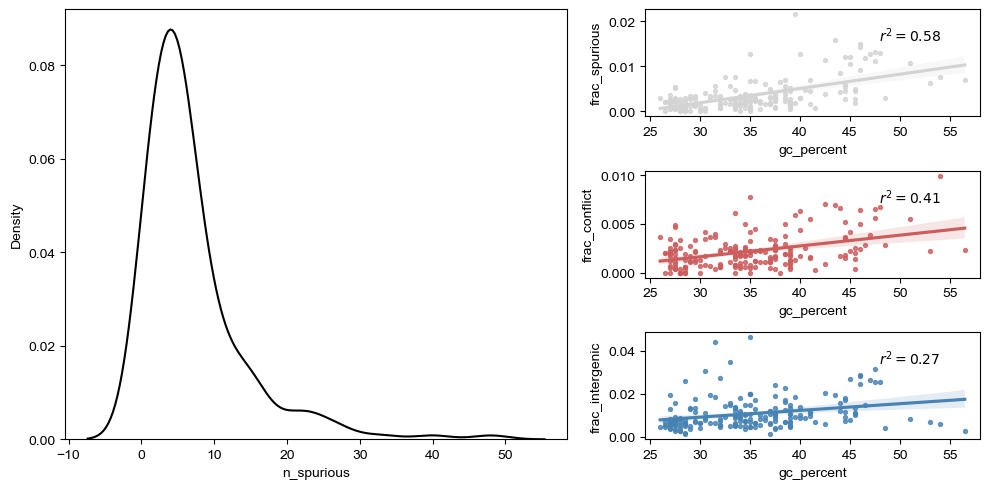

In [134]:
def figure_1(results_df, threshold:float=0.5):

    fig = plt.figure(figsize=(10, 5), layout='tight')
    grid = GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[0.6, 0.4])
    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = [fig.add_subplot(grid[i, 1]) for i in range(3)]

    results_df = apply_threshold(results_df, threshold=threshold)
    genomes = results_df.groupby('genome_id')

    ax_df = pd.DataFrame(index=results_df['genome_id'].unique())
    ax_df['gc_percent'] = genomes.gc_percent.first()
    ax_df['genome_size'] = genomes.apply(len, include_groups=False)
    ax_df['n_spurious'] = genomes.apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    ax_df['n_spurious_match'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'match')).sum(), include_groups=False)
    ax_df['n_spurious_intergenic'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'intergenic')).sum(), include_groups=False)
    ax_df['n_spurious_conflict'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'conflict')).sum(), include_groups=False)
    
    ax_df['n_intergenic'] = genomes.apply(lambda df : (df.category == 'intergenic').sum(), include_groups=False)
    ax_df['n_conflict'] = genomes.apply(lambda df : (df.category == 'conflict').sum(), include_groups=False)
    
    ax_df['frac_spurious'] = ax_df.n_spurious / ax_df.genome_size
    ax_df['frac_intergenic'] = ax_df.n_intergenic / ax_df.genome_size
    ax_df['frac_conflict'] = ax_df.n_conflict / ax_df.genome_size

    sns.kdeplot(data=ax_df, x='n_spurious', ax=ax_a, label='spurious', color='black', linestyle='-')
    # sns.kdeplot(data=ax_df, x='n_spurious_match', ax=ax_a, color='darkseagreen', label='spurious match')
    # sns.kdeplot(data=ax_df, x='n_spurious_intergenic', ax=ax_a, color='steelblue', label='spurious intergenic')
    # sns.kdeplot(data=ax_df, x='n_spurious_conflict', ax=ax_a, color='indianred', label='spurious conflict')

    palette = {'frac_spurious':'lightgray', 'frac_conflict':'indianred', 'frac_intergenic':'steelblue'}
    for y, ax in zip(['frac_spurious', 'frac_conflict', 'frac_intergenic'], ax_b):
        sns.regplot(data=ax_df, x='gc_percent', y=y, ax=ax, color=palette.get(y), scatter_kws={'s':8})
        r = pearsonr(ax_df['gc_percent'].values, ax_df[y].values)
        ax.text(0.7, 0.7, f'$r^2={r.statistic:.2f}$', transform=ax.transAxes)

    fig.tight_layout()
    plt.show()

figure_1(results_df, threshold=0.99)

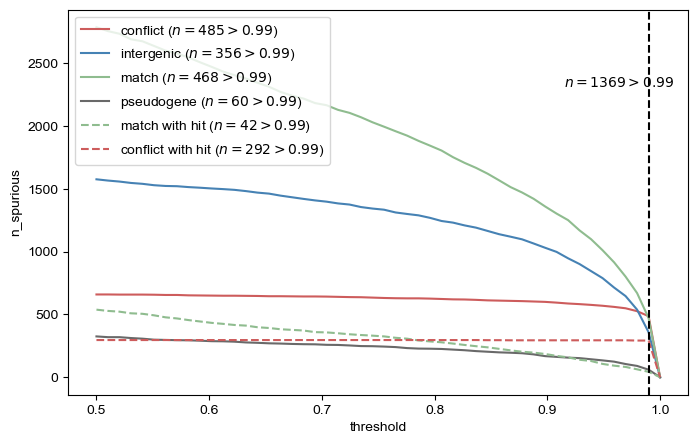

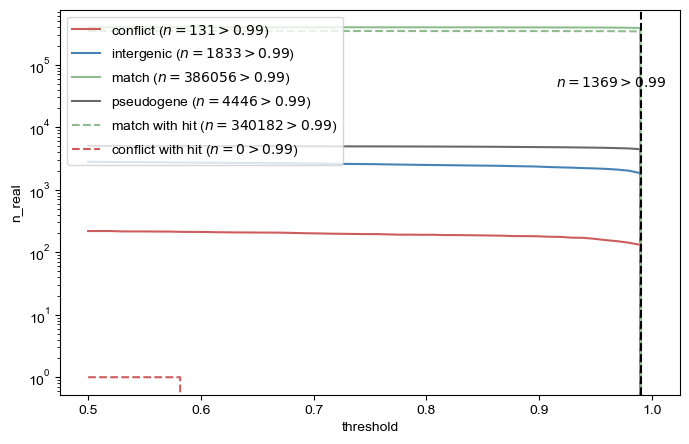

In [136]:
def figure(results_df:pd.DataFrame, path:str=None, threshold:float=0.99, label:int=0, log_scale:bool=False):

    results_df = results_df.copy()
    results_df['interpro_hit'] = has_interpro_hit(results_df, include_mdb=False)
    results_df['antifam_hit'] = has_antifam_hit(results_df)

    thresholds = np.linspace(0.5, 1, 50)
    y_label = 'n_spurious' if (label == 0) else 'n_real'

    fig, ax = plt.subplots(figsize=(8, 5))

    def get_ax_df(df:pd.DataFrame):
        ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
        ax_df['threshold'] = thresholds
        ax_df[y_label] = [(df[f'model_output_{label}'] > threshold_).sum() for threshold_ in thresholds]
        return ax_df

    palette = {'intergenic':'steelblue', 'conflict':'indianred', 'match':'darkseagreen', 'pseudogene':'dimgray'}
    for category, df in results_df.groupby('category'):
        n = (df[f'model_output_{label}'] > threshold).sum()
        sns.lineplot(ax=ax, data=get_ax_df(df), x='threshold', y=y_label, color=palette.get(category), label=f'{category} ($n={n} > {threshold}$)')
    
    df = results_df[(results_df.category == 'match') & results_df.interpro_hit]
    n = (df[f'model_output_{label}'] > threshold).sum()
    sns.lineplot(ax=ax, data=get_ax_df(df), x='threshold', y=y_label, color=palette.get('match'), linestyle='--', label=f'match with hit ($n={n} > {threshold}$)')

    df = results_df[(results_df.category == 'conflict') & results_df.antifam_hit]
    n = (df[f'model_output_{label}'] > threshold).sum()
    sns.lineplot(ax=ax, data=get_ax_df(df), x='threshold', y=y_label, color=palette.get('conflict'), linestyle='--', label=f'conflict with hit ($n={n} > {threshold}$)')
    
    sns.move_legend(ax, 'lower left')
    ax.legend(loc='upper left')

    ax.axvline(x=threshold, linestyle='--', color='black')
    n = (results_df.model_output_0 > threshold).sum()
    ax.text(0.8, 0.8, f'$n={n} > {threshold}$', transform=ax.transAxes)

    if log_scale:
        ax.set_yscale('log')

    plt.show()

figure(results_df, label=0)
figure(results_df, label=1, log_scale=True)


In [137]:
dataset_df = pd.read_csv('../data/dataset_dereplicated.csv', index_col=0)

# Going to try fine-tuning the model using the Prodigal data, though I don't want to train it on a bunch of sequences which 
# are basically already in the training dataset (i.e. all of the high-confidence match sequences). 

threshold = 0.99
label_1_mask = (results_df.model_output_1 > threshold) & ~((results_df.category == 'match') & (results_df.top_hit_protein_id.isin(dataset_df.index)))
label_0_mask = (results_df.model_output_0 > threshold)

print('Adding', label_1_mask.sum(), 'likely "real" sequences to the tuning dataset.')
print('Adding', label_0_mask.sum(), 'likely "spurious" sequences to the tuning dataset.')

tune_dataset_df = list()
tune_dataset_df += [results_df[label_1_mask].assign(label=1)]
tune_dataset_df += [results_df[label_0_mask].assign(label=0)]
tune_dataset_df = pd.concat(tune_dataset_df)

tune_dataset_df.to_csv('../data/dataset_tune.csv')


Adding 46979 likely "real" sequences to the tuning dataset.
Adding 1369 likely "spurious" sequences to the tuning dataset.


In [114]:
query_dfs = dict()
query_dfs['suspect_match'] = results_df[is_suspect_match(results_df)].copy().rename(columns={'query_seq':'seq'})
query_dfs['intergenic'] = results_df[results_df.category == 'intergenic'].copy().rename(columns={'query_seq':'seq'})

mmseqs = MMSeqs()

subject_name = 'dataset_train'
subject_df = pd.read_csv(f'../data/{subject_name}.csv', index_col=0)
subject_df = subject_df.drop_duplicates('seq')

align_dfs = dict()
for query_name, query_df in query_dfs.items():
    add_cols = ['genome_id', 'contig_id', 'model_label', 'seq', 'label', 'product', 'category', 'top_hit_protein_id']
    align_df = mmseqs.align(query_df=query_df, subject_df=subject_df, query_name=query_name, output_dir='../data/results/', subject_name=subject_name, sensitivity=7, add_cols=add_cols)

    align_df = align_df.sort_values('e_value')
    align_df = align_df.drop_duplicates('query_id')
    align_dfs[query_name] = align_df 

    print('Query name:', query_name)
    print(f'Number of query sequences:', len(query_df))
    print(f'Number of sequences with alignments in {subject_name}.csv:', len(align_df), f'({100 * len(align_df) / len(query_df):.2f}%)')
    print(f'Number of predicted spurious:', (query_df.model_label == 0).sum())
    print(f'Number of predicted spurious with an alignment:', (align_df.query_model_label == 0).sum())
    print(f'Number of sequences with best alignments to spurious sequences:', (align_df.subject_label == 0).sum())
    print()

Query name: suspect_match
Number of query sequences: 41420
Number of sequences with alignments in dataset_train.csv: 36208 (87.42%)
Number of predicted spurious: 1933
Number of predicted spurious with an alignment: 1520
Number of sequences with best alignments to spurious sequences: 53

Query name: intergenic
Number of query sequences: 4372
Number of sequences with alignments in dataset_train.csv: 2962 (67.75%)
Number of predicted spurious: 1576
Number of predicted spurious with an alignment: 1076
Number of sequences with best alignments to spurious sequences: 16



In [115]:
align_dfs['suspect_match'].subject_product.value_counts()

is_same_genome = lambda df : df.query_genome_id == df.subject_genome_id
is_same_contig = lambda df : np.array([id_.split('.')[0] for id_ in df.query_id]) == df.subject_contig_id
# Compute the traditional sequence identity (with match score 1, gap score 0, and mismatch score 0).
get_sequence_identity_ = lambda df : (df.alignment_length - (df.n_gaps + df.n_mismatches)) / df.alignment_length 

align_df = align_dfs['suspect_match'].copy()
align_df['sequence_identity_'] = get_sequence_identity_(align_df)
align_df[is_same_contig(align_df)] # [['sequence_identity_', 'sequence_identity']]


# Something weird seems to be happening where a lot of the "suspect" sequences have similar sequences in other genomes, 
# and sometimes in the same genome. Sometimes the sequences they aligned to are annotated, though most are hypothetical. 
# It is not clear to me why these sequences were not recognized by PGAP. I did check to make sure there were no bugs in my code,
# and the sequences I have as "suspect matches" are indeed aligned to suspect sequences in the reference genome.

,query_id,subject_id,sequence_identity,alignment_length,n_mismatches,n_gaps,query_alignment_start,query_alignment_stop,subject_alignment_start,subject_alignment_stop,...,query_model_label,query_seq,query_category,query_top_hit_protein_id,subject_genome_id,subject_contig_id,subject_seq,subject_label,subject_product,sequence_identity_
506191,NZ_CP021886.1_279,WP_108910362.1,0.742,1275,317,0,0,1275,0,1230,...,1,MSNKSFYVSPIINSGGGGNNTPIETIKVNVKDYVLNLDFKSNVKTL...,match,WP_108910457.1,GCF_003097575.1,NZ_CP021886,MSNKSFYVSPIINSGGGGNNTPIETIKVNVKDYVLNLDFKSNVKTL...,1,autotransporter outer membrane beta-barrel dom...,0.751373
298874,NZ_CP021886.1_607,WP_108910817.1,0.546,1212,524,0,0,1155,0,1212,...,1,MKNESHNFSLISNLPSSSLFLSFSLITALNTSLVADSWATSGTITL...,match,WP_108910700.1,GCF_003097575.1,NZ_CP021886,MPHSTPIETIKVNVKDYVLNLDFKGNPKPLDSQSLNMNFDYKYSKL...,1,autotransporter outer membrane beta-barrel dom...,0.567657
277960,NZ_AP023046.1_1602,WP_176486428.1,0.922,607,47,0,0,607,0,607,...,1,MLLSLNGLNKGAREYKAEITRQSILKVKNAKDLSQEQKSQIYRDRN...,match,WP_176486515.1,GCF_013374215.1,NZ_AP023046,MLLSLNGLNKGAREYKAEITRQSILKVKNAKDLSQEQKSQIYRDRN...,1,hypothetical protein,0.922570
345355,NZ_CP021886.1_756,WP_108910564.1,0.478,1300,363,0,0,696,0,1300,...,1,MTPSIGNLIIKEGGILQGGDNHSAIAIDANPQHKFTGNIQIEGTLK...,match,WP_108910827.1,GCF_003097575.1,NZ_CP021886,MQNSMLTLTTLIPSGGGGKIMPHSTPIETIKVNVKDYVLNLDFKSN...,1,autotransporter outer membrane beta-barrel dom...,0.720769
393689,NZ_CP014991.1_1287,WP_066389031.1,0.806,1203,207,0,0,1067,0,1203,...,1,MPMGGNIATILNNGTLTGGLTNQEGGSIGTFTHASTTVLDSLTNIG...,match,WP_066389051.1,GCF_001602095.1,NZ_CP014991,MQNLHNNFDLSSITNTGSINELNNASNITITTLTNQTNGRITTLNN...,1,beta strand repeat-containing protein,0.827930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411897,NZ_CP054052.1_712,WP_083574671.1,0.131,696,145,0,0,696,0,168,...,1,MKKILLSAALCSSLLFANYNDAGTDYTNAITKSFTEESTLQPINTV...,match,WP_071626175.1,GCF_013283835.1,NZ_CP054052,MNYLKAVLKKDHETKIKELKKLIVLGEKLNKNTTPDKKKLEILIER...,1,N-acetylmuramoyl-L-alanine amidase,0.791667
234828,NZ_CP041070.1_1177,WP_129082329.1,0.345,44,15,0,0,44,0,24,...,1,MLKNKKLILKVMYYYNLIKAKKIDNYLLIIGILGVVIGLYFSIPII...,match,WP_129081888.1,GCF_006459125.1,NZ_CP041070,MKIFNYRLVIFILSIIFGIVFSIPSFLQTETGKKISLGLDLQGGLH...,1,protein translocase subunit SecD,0.659091
28991,NZ_CP100595.1_1003,WP_254577883.1,0.156,251,76,0,0,91,0,251,...,1,MKDKIVFYLAIWGALLSSILGYFQIQEYLTPKHTIYIDAQISATNN...,match,WP_254577652.1,GCF_024267655.1,NZ_CP100595,MCTDCGCSITDHHHHDHEHSHGDSQTHQAAHETLHHNPQLNDSKTV...,1,hydrogenase nickel incorporation protein HypB,0.697211
8274,NC_012115.1_1453,WP_012663552.1,0.126,743,33,0,0,39,0,743,...,1,MDARKLNKLLKRLEEKQKEEAKLSAKVEKLKTEIKDLEKQIQEELTGNY,match,WP_012663583.1,GCF_000021725.1,NC_012115,MDIRKKFLEFFESKGHKVYPSAPLVPDDPTLLFTNAGMVPFKPIFT...,1,alanine--tRNA ligase,0.955585


0
41420
1
2
3


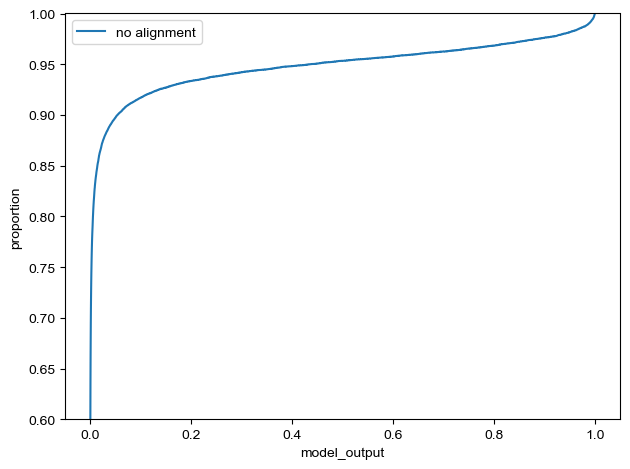

In [119]:
# First curious about the intergenic sequences, many of which I suspect are actually spurious. 
# Some are probaly actually conflicts, because of how lenient I was about the overlap length. 

# There seems to be no real correlation between overlap length and model output. 

# I was worried that the model would fail to catch some of the short, spurious ORFs that might
# not have any homology to known spurious translations. However, this does not seem to be the case. 

# What is making the model decide that some intergenic sequences are real and some are spurious?
# Do any of them bear any homology to known sequences? Could do an MMSeqs alignment against all the
# Campylobacterota sequences. 

def figure_4(results_df:pd.DataFrame, align_df:pd.DataFrame, mask_func=None, path:str=None, thresholds:list=[10, 1e-5, 1e-10, 1e-20]):

    results_df = results_df.copy()
    results_df = results_df[mask_func(results_df)].copy()
    # is_hypothetical = lambda df : df.top_hit_product.str.contains('hypothetical', flags=re.IGNORECASE) | df.top_hit_product.str.contains('Uncharacterized', flags=re.IGNORECASE)

    fig, ax = plt.subplots()

    cmap = cm.get_cmap('coolwarm')
    for i, threshold in enumerate(thresholds):
        print(i)
        df = align_df[(align_df.e_value < threshold) & (align_df.subject_label == 1)].copy()
        df = df.sort_values('e_value')
        df = df.drop_duplicates('query_id').set_index('query_id')

        ax_df = pd.DataFrame(index=results_df.index)
        ax_df['alignment'] = ax_df.index.isin(df.index)
        ax_df['subject_product'] = df.subject_product
        ax_df['subject_product'] = np.where(ax_df.subject_product.isnull(), 'none', ax_df.subject_product) 
        # ax_df['annotated_alignment'] = ax_df.alignment & (~ax_df.subject_product.str.contains('hypothetical'))
        ax_df['model_output'] = results_df['model_output_0']

        if threshold == 10:
            print((~ax_df.alignment).sum())
            sns.ecdfplot(ax=ax, data=ax_df[~ax_df.alignment], x='model_output', label='no alignment')

        sns.ecdfplot(ax=ax, data=ax_df[ax_df.alignment], x='model_output', label=f'any alignment (E-value < {threshold:.0e})', color=cmap((i + 1) / len(thresholds)))
        # sns.ecdfplot(ax=ax, data=ax_df[ax_df.annotated_alignment], x='model_output', linestyle='--', label=f'annotated alignment (E-value < {threshold:.0e})', color=cmap((i + 1) / len(thresholds)))

    ax.legend()
    ax.set_ylim(ymin=0.6)
    ax.set_ylabel('proportion')

    fig.tight_layout()
    plt.show()


# What are all of these sequences with strong alignments to something in the training set, but predicted to be spurious?
figure_4(results_df, align_dfs['intergenic'], mask_func=is_suspect_match)
# figure_4(results_df, align_dfs['intergenic'], mask_func=is_intergenic)
    

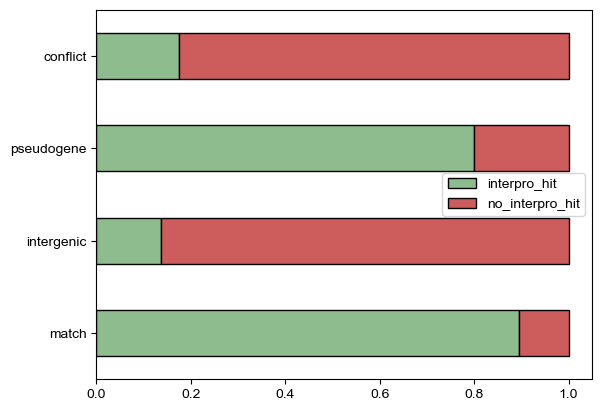

In [120]:
# TODO: This could probably just be a table.

def figure_5(results_df, path:str=None, max_e_value:float=10, include_mdb:bool=True):

    results_df = results_df.copy()
    results_df['interpro_hit'] = has_interpro_hit(results_df, max_e_value=max_e_value, include_mdb=include_mdb)

    ax_df = pd.DataFrame(index=results_df.category.unique(), columns=['interpro_hit', 'no_interpro_hit'])
    for category, df in results_df.groupby('category'):
        ax_df.loc[category, 'interpro_hit'] = df.interpro_hit.sum() / len(df)
        ax_df.loc[category, 'no_interpro_hit'] = (~df.interpro_hit).sum() / len(df)
    
    fig, ax = plt.subplots()

    palette = {'interpro_hit':'darkseagreen', 'no_interpro_hit':'indianred'}
    ax_df.plot(kind='barh', ax=ax, stacked=True, edgecolor='black', color=palette)
    plt.show()

figure_5(results_df)

In [124]:
    # ax_a_df = results_df[['model_output_0', 'overlap_length', 'top_hit_overlap_fraction', 'query_overlap_fraction', 'same_strand', 'top_hit_feature']].copy()
    # ax_a_df = ax_a_df[ax_a_df.overlap_length > 0].copy()
    # ax_a_df['top_hit_feature'] = ax_a_df.top_hit_feature.replace({'rRNA':'RNA', 'tRNA':'RNA', 'ncRNA':'RNA'})
    # hue_order = ['CDS', 'RNA', 'repeat_region', 'misc_feature', 'regulatory']
    # ax_a_df = ax_a_df.sort_values('top_hit_feature', key=np.vectorize(hue_order.index))
    # ax_a_df['overlap_length'] += np.random.uniform(low=-1, high=1, size=len(ax_a_df)) * 0.5

    # palette = {'CDS':'darkseagreen', 'RNA':'indianred', 'repeat_region':'steelblue', 'misc_feature':'dimgray', 'regulatory':'steelblue'}
    # sns.scatterplot(data=ax_a_df, x='overlap_length', y='model_output_0', hue='top_hit_feature', palette=palette)

    # ax_a_df = pd.DataFrame(index=np.arange(len(results_df) + len(antifam_df)))
    # ax_a_df['length'] = list(results_df.query_seq.apply(len)) + list(antifam_df.seq.apply(len))
    # ax_a_df['source'] = list(np.where(results_df.model_label == 0, 'intergenic spurious', 'intergenic real')) + ['AntiFam'] * len(antifam_df)
    # sns.kdeplot(data=ax_a_df, x='length', hue='source', common_norm=False, ax=ax)


In [ ]:
# def figure_2(results_df, threshold:float=0.5, remove_suspect_match:bool=False):
    
#     results_df = apply_threshold(results_df, threshold=threshold)
#     results_df = results_df[results_df.model_label == 0].copy()
#     results_df['suspect_match'] = is_suspect_match(results_df)

#     # What fraction of the matches are suspect? These were not included in the training set. 
#     # It's unclear if it's actually finding real sequences, or if it's just flagging things it doesn't recognize as spurious.
#     print(f'figure_2: {results_df.suspect_match.sum()} of the spurious matches are suspect.')

#     if remove_suspect_match:
#         print(f'figure_2: Removing {results_df.suspect_match.sum()} suspect matches.')
#         results_df = results_df[~results_df.suspect_match].copy()

#     fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))
    
#     ax_a_df = pd.DataFrame(index=results_df.category.unique())
#     ax_a_df['category'] = ax_a_df.index
#     ax_a_df['count'] = results_df.value_counts('category')

#     sns.barplot(data=ax_a_df, ax=ax_a, y='count', x='category', color='lightgray', edgecolor='black')

#     ax_b_df = results_df[['model_output_0', 'category']].copy()

#     palette = {'intergenic':'steelblue', 'conflict':'indianred', 'match':'darkseagreen', 'pseudogene':'dimgray'}
#     sns.ecdfplot(data=ax_b_df, x='model_output_0', hue='category', palette=palette, ax=ax_b)

# figure_2(results_df, remove_suspect_match=False)
